## Importing libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.xception import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, Input
from PIL import Image, ImageOps
import random

## Setting seed

In [2]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [3]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [4]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [5]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [6]:
input_tensor = Input(shape=(224, 224, 3))

base_model = Xception(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [7]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - loss: 22963.0273 - mae: 118.8766 - val_loss: 10306.2529 - val_mae: 66.0236
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - loss: 10364.0879 - mae: 73.4137 - val_loss: 6240.3364 - val_mae: 56.9844
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - loss: 5062.6807 - mae: 51.9918 - val_loss: 5993.5386 - val_mae: 51.7487
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - loss: 4168.7705 - mae: 44.9561 - val_loss: 6059.4604 - val_mae: 58.0971
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - loss: 2892.5806 - mae: 38.2439 - val_loss: 5590.4590 - val_mae: 55.9837
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - loss: 2373.5190 - mae: 35.1432 - val_loss: 5064.6924 - val_mae: 50.5252
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - loss: 2647.0769 - mae: 34.3264 - val_loss: 5442.6333 - val_mae: 56.7244
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - loss: 2229.9292 - mae: 33.0007 - val_loss: 5181.0635 - val_mae: 51.5764
Epoc

## Training curves visualisation

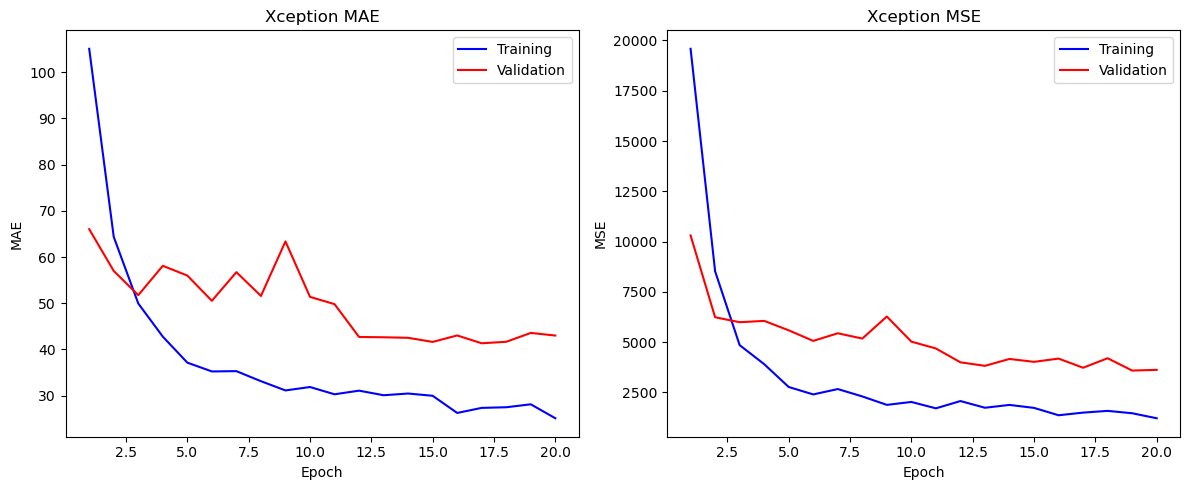

In [8]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Xception MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Xception MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [9]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


'input_layer_4', 'block1_conv1', 'block1_conv1_bn', 'block1_conv1_act', 'block1_conv2', 'block1_conv2_bn', 'block1_conv2_act', 'block2_sepconv1', 'block2_sepconv1_bn', 'block2_sepconv2_act', 'block2_sepconv2', 'block2_sepconv2_bn', 'conv2d_12', 'block2_pool', 'batch_normalization_12', 'add_36', 'block3_sepconv1_act', 'block3_sepconv1', 'block3_sepconv1_bn', 'block3_sepconv2_act', 'block3_sepconv2', 'block3_sepconv2_bn', 'conv2d_13', 'block3_pool', 'batch_normalization_13', 'add_37', 'block4_sepconv1_act', 'block4_sepconv1', 'block4_sepconv1_bn', 'block4_sepconv2_act', 'block4_sepconv2', 'block4_sepconv2_bn', 'conv2d_14', 'block4_pool', 'batch_normalization_14', 'add_38', 'block5_sepconv1_act', 'block5_sepconv1', 'block5_sepconv1_bn', 'block5_sepconv2_act', 'block5_sepconv2', 'block5_sepconv2_bn', 'block5_sepconv3_act', 'block5_sepconv3', 'block5_sepconv3_bn', 'add_39', 'block6_sepconv1_act', 'block6_sepconv1', 'block6_sepconv1_bn', 'block6_sepconv2_act', 'block6_sepconv2', 'block6_sepconv2_bn', 'block6_sepconv3_act', 'block6_sepconv3', 'block6_sepconv3_bn', 'add_40', 'block7_sepconv1_act', 'block7_sepconv1', 'block7_sepconv1_bn', 'block7_sepconv2_act', 'block7_sepconv2', 'block7_sepconv2_bn', 'block7_sepconv3_act', 'block7_sepconv3', 'block7_sepconv3_bn', 'add_41', 'block8_sepconv1_act', 'block8_sepconv1', 'block8_sepconv1_bn', 'block8_sepconv2_act', 'block8_sepconv2', 'block8_sepconv2_bn', 'block8_sepconv3_act', 'block8_sepconv3', 'block8_sepconv3_bn', 'add_42', 'block9_sepconv1_act', 'block9_sepconv1', 'block9_sepconv1_bn', 'block9_sepconv2_act', 'block9_sepconv2', 'block9_sepconv2_bn', 'block9_sepconv3_act', 'block9_sepconv3', 'block9_sepconv3_bn', 'add_43', 'block10_sepconv1_act', 'block10_sepconv1', 'block10_sepconv1_bn', 'block10_sepconv2_act', 'block10_sepconv2', 'block10_sepconv2_bn', 'block10_sepconv3_act', 'block10_sepconv3', 'block10_sepconv3_bn', 'add_44', 'block11_sepconv1_act', 'block11_sepconv1', 'block11_sepconv1_bn', 'block11_sepconv2_act', 'block11_sepconv2', 'block11_sepconv2_bn', 'block11_sepconv3_act', 'block11_sepconv3', 'block11_sepconv3_bn', 'add_45', 'block12_sepconv1_act', 'block12_sepconv1', 'block12_sepconv1_bn', 'block12_sepconv2_act', 'block12_sepconv2', 'block12_sepconv2_bn', 'block12_sepconv3_act', 'block12_sepconv3', 'block12_sepconv3_bn', 'add_46', 'block13_sepconv1_act', 'block13_sepconv1', 'block13_sepconv1_bn', 'block13_sepconv2_act', 'block13_sepconv2', 'block13_sepconv2_bn', 'conv2d_15', 'block13_pool', 'batch_normalization_15', 'add_47', 'block14_sepconv1', 'block14_sepconv1_bn', 'block14_sepconv1_act', 'block14_sepconv2', 'block14_sepconv2_bn', 'block14_sepconv2_act', 'flatten_3', 'dropout_6', 'dense_9', 'dropout_7', 'dense_10', 'dense_11'

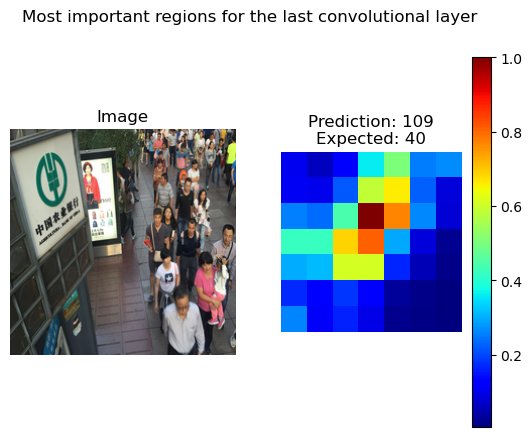

In [11]:
# Sample
image = X_test[20:21]

# Layer
last_conv_layer_name = 'block14_sepconv2_act'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = (image[0] + 1.0) / 2.0
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[20]}")

plt.show()

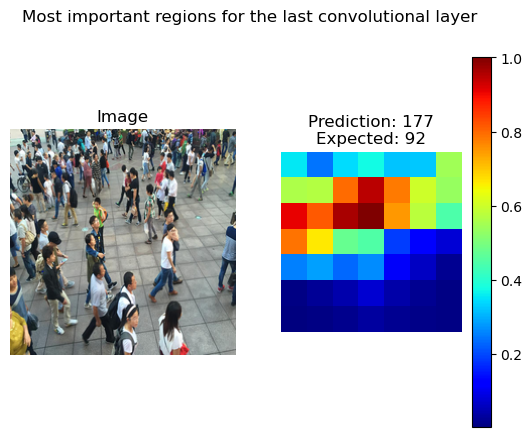

In [12]:
# Sample
image = X_test[211:212]

# Layer
last_conv_layer_name = 'block14_sepconv2_act'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
# Results
image_norm = (image[0] + 1.0) / 2.0
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[211]}")

plt.show()

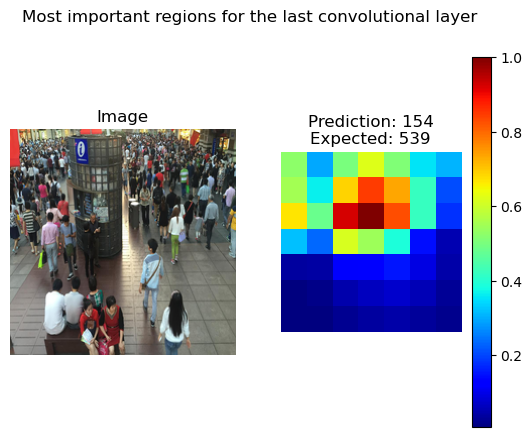

In [13]:
# Sample
image = X_test[289:290]

# Layer
last_conv_layer_name = 'block14_sepconv2_act'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = (image[0] + 1.0) / 2.0
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[289]}")

plt.show()

In [19]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 39.  23.]
 [126. 181.]
 [188. 157.]
 [ 56.  37.]
 [115.  70.]
 [ 94.  57.]
 [ 68.  44.]
 [273. 227.]
 [174. 165.]
 [283. 476.]
 [148. 139.]
 [258. 316.]
 [235. 164.]
 [107. 110.]
 [ 41.  20.]
 [192. 131.]
 [ 54.  48.]
 [196. 183.]
 [140. 101.]
 [272. 204.]
 [109.  40.]
 [106. 143.]
 [137. 146.]
 [284. 513.]
 [150.  70.]
 [160. 175.]
 [ 80.  51.]
 [ 96.  55.]
 [ 96.  67.]
 [129.  72.]
 [ 55.  56.]
 [142. 165.]
 [ 49.  32.]
 [181. 149.]
 [ 98.  48.]
 [138.  80.]
 [129. 117.]
 [132. 162.]
 [163. 137.]
 [134. 120.]
 [108.  72.]
 [ 99. 122.]
 [223. 198.]
 [141. 133.]
 [197. 147.]
 [ 44.  29.]
 [124.  70.]
 [121.  35.]
 [ 84.  24.]
 [260. 251.]
 [ 48.  59.]
 [180.  67.]
 [ 86.  61.]
 [284. 248.]
 [202. 252.]
 [267. 147.]
 [ 43.  57.]
 [176. 121.]
 [ 64.  47.]
 [361. 505.]
 [235. 297.]
 [249. 465.]
 [196. 167.]
 [ 90.  43.]
 [ 44.  46.]
 [ 95.  91.]
 [217. 263.]
 [222.  92.]
 [118. 117.]
 [110.  48.]
 [ 53.  54.]
 [111.  73.]
 [131. 122.]
 [135.  60.]
 [198. 170.]
 [230. 167.]
 [ 62.  57.]

## Metrics

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.5993375778198242
MSE: 3626.0537109375
MAE: 43.01582336425781
RMSE: 60.21672439575195
